<a href="https://colab.research.google.com/github/hamidahoderinwale/model_metadata_analyses/blob/main/scraping_hf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Script 1
Takes in a (validated) model url and output its metadata

In [ ]:
# Script 1: takes input model url, validates url, and gives model metadata
!pip install validators
from huggingface_hub import HfApi
import huggingface_hub as hf
import validators
import json
import csv

hf_api = HfApi()

def input_url():
    while True:
        input_model_url = input("Enter model URL: ")
        print(f"You entered: {input_model_url}")

        if validators.url(input_model_url) and "huggingface.co" in input_model_url:
                # Extract the model ID from the URL
                model_id = input_model_url.split("huggingface.co/")[-1]
                model_info = hf_api.model_info(model_id) # Get model info: https://huggingface.co/docs/huggingface_hub/v0.29.2/en/package_reference/hf_api#huggingface_hub.ModelInfo
                model_card = hf.hf_hub_download(models[0].modelId, 'README.md')

                metadata = { # Moved metadata assignment inside the if block
                    "model_id": model_id,
                    "model_info": model_info.__dict__
                }
                return metadata # Return is now inside if block
                json_output = json.dumps(metadata, indent=4, default=str)
                with open('model_info.json', 'w') as json_file:
                 json_file.write(json_output)
                print(json_output)
        else:
            print("Invalid URL. Please enter a valid Hugging Face model URL.")
            # Optionally: You could return None or an empty dictionary here
            # to indicate an invalid URL
# To test: https://huggingface.co/deepseek-ai/DeepSeek-R1

input_url()


Enter model URL: https://huggingface.co/deepseek-ai/DeepSeek-R1
You entered: https://huggingface.co/deepseek-ai/DeepSeek-R1


{'model_id': 'deepseek-ai/DeepSeek-R1',
 'model_info': {'id': 'deepseek-ai/DeepSeek-R1',
  'author': 'deepseek-ai',
  'sha': '56d4cbbb4d29f4355bab4b9a39ccb717a14ad5ad',
  'last_modified': datetime.datetime(2025, 3, 27, 4, 1, 59, tzinfo=datetime.timezone.utc),
  'created_at': datetime.datetime(2025, 1, 20, 3, 46, 7, tzinfo=datetime.timezone.utc),
  'private': False,
  'gated': False,
  'disabled': False,
  'downloads': 1342593,
  'downloads_all_time': None,
  'likes': 11857,
  'library_name': 'transformers',
  'gguf': None,
  'inference': 'warm',
  'inference_provider_mapping': None,
  'tags': ['transformers',
   'safetensors',
   'deepseek_v3',
   'text-generation',
   'conversational',
   'custom_code',
   'arxiv:2501.12948',
   'license:mit',
   'autotrain_compatible',
   'endpoints_compatible',
   'fp8',
   'region:us'],
  'pipeline_tag': 'text-generation',
  'mask_token': None,
  'trending_score': None,
  'card_data': {'base_model': None, 'datasets': None, 'eval_results': None, 'la

# Script 2
Takes in a (validated) model and outputs the children models/fine-tunes

In [ ]:
# Script 2
  # 1. Take link as input (format check). This is the "main model"
  # 2. Give the link to the page with the fine-tunes for the inputted model

from huggingface_hub import HfApi
import requests
from bs4 import BeautifulSoup
import re

# Initialize API
api = HfApi()

# Function to validate Hugging Face model URL
def validate_hf_model_url(url):
    pattern = r"^https://huggingface.co/([\w\-]+)/([\w\-]+)$"
    match = re.match(pattern, url)
    if match:
        return match.groups()  # Returns (org/user, model_name)
    return None

# Function to find fine-tuned models
def get_finetuned_models_page(model_org, model_name):
    search_url = f"https://huggingface.co/models?search={model_name}"
    response = requests.get(search_url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        model_links = [
            a["href"] for a in soup.find_all("a", href=True)
            if model_name.lower() in a["href"].lower()
        ]
        return [f"https://huggingface.co{link}" for link in model_links if model_org not in link]

    return []

# Main execution
model_url = input("Enter the Hugging Face model URL: ").strip()

validated = validate_hf_model_url(model_url)
if validated:
    org, model_name = validated
    finetune_links = get_finetuned_models_page(org, model_name)

    if finetune_links:
        print("Fine-tuned models found:")
        for link in finetune_links:
            print(link)
    else:
        print("No fine-tuned models found for this model.")
else:
    print("Invalid Hugging Face model URL format.")



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-117-ebc51be474d6>", line 37, in <cell line: 0>
    model_url = input("Enter the Hugging Face model URL: ").strip()
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 1177, in raw_input
    return self._input_request(
           ^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/ipykernel/kernelbase.py", line 1219, in _input_request
    raise KeyboardInterrupt("Interrupted by user") from None
KeyboardInterrupt: Interrupted by user

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_tr

TypeError: object of type 'NoneType' has no len()

# Script 3
## Search steps overview
- `dfs_finetunes` we take the `model_url` as input. Alternatively, we can add this var as an argument.
- We go layer-by-layer and find the children of the current model (i.e. the fine-tunes of a model)
- We call the `dfs_funetunes` function recursively and store the models that have been "visited" to avoid duplicates.
- We have a dictionary of information that we store about the "current model" and have the information stored in respective columns (model_id, card, metadata, depth, children (list of model links), children count).
- We have a `results` list that has the information about all the models and their fine-tunes.

In [31]:
# Script 3
!pip install huggingface_hub
!pip install adapters
import requests
import pandas as pd
import datetime
import json
import csv
from huggingface_hub import HfApi
from bs4 import BeautifulSoup
from adapters import list_adapters
from huggingface_hub import hf_hub_download
from adapters import AutoAdapterModel
import re



# Initialize API
api = HfApi()

# Function to validate Hugging Face model URL
def validate_hf_model_url(url):
    pattern = r"^https://huggingface.co/([\w\-]+)/([\w\-]+)$"
    match = re.match(pattern, url)
    return match.groups() if match else None

# page with model finetunes
def get_finetuned_models_page(model_org, model_name):
    all_model_links = []  # Store all links across pages
    page_num = 0
    while True:
        search_url = f"https://huggingface.co/models?other=base_model:finetune:{model_org}/{model_name}&p={page_num}"
        response = requests.get(search_url)
        if response.status_code != 200:
            break  # Exit if page not found

        soup = BeautifulSoup(response.text, "html.parser")
        model_divs = soup.find_all("div", class_="w-full truncate")
        if not model_divs:
            break  # Exit if no more models on the page

        for div in model_divs:
            header = div.find("header")
            if header:
                model_link = header.get("title")
                if model_link:
                    all_model_links.append(f"https://huggingface.co/{model_link}")

        page_num += 1  # Move to the next page

    return all_model_links

# model card data
def get_model_card(model_id):
    try:
        # Try to download model card if available
        readme_path = hf_hub_download(repo_id=model_id, filename='README.md')
        with open(readme_path, 'r', encoding='utf-8') as f:
            card_content = f.read()
        return card_content
    except Exception as e:
        print(f"  Could not download model card: {str(e)[:100]}...")
        return ""


# Function to get parent model
def get_parent_model(model_url):
    return model_url.split(f"/{model_name}/")[0]

# Truncate metadata
def filter_metadata(json_metadata):
            keys_to_keep = ["modelId", "sha", "tags", "downloads", "pipeline_tag"]
            return {k: json_metadata.get(k) for k in keys_to_keep if k in json_metadata}
            filtered_metadata = filter_metadata(api.model_info(model_id).__dict__)

# Get adapter models
def get_adapter_models_page(model_org, model_name):
    all_adapter_links = []  # Store all adapter links across pages
    page_num = 0
    while True:
        search_url = f"https://huggingface.co/models?other=base_model:adapter:{model_org}/{model_name}&p={page_num}"
        response = requests.get(search_url)
        if response.status_code != 200:
            break  # Exit if page not found

        soup = BeautifulSoup(response.text, "html.parser")
        model_divs = soup.find_all("div", class_="w-full truncate")
        if not model_divs:
            break  # Exit if no more models on the page

        for div in model_divs:
            header = div.find("header")
            if header:
                model_link = header.get("title")
                if model_link:
                    all_adapter_links.append(f"https://huggingface.co/{model_link}")

        page_num += 1  # Move to the next page

    return all_adapter_links

# Recursive DFS (depth-first search) for finding fine-tunes
def dfs_finetunes(model_url, visited, depth=0, results=None):
       if results is None:
           results = []

       if model_url in visited:
           return results
       visited.add(model_url)

       validated = validate_hf_model_url(model_url)
       if not validated:
           print(f"Invalid URL skipped: {model_url}")
           model_url = "N/A"
           return results

       model_org, model_name = validated
       model_id = f"{model_org}/{model_name}"


       print(f"\n{'  ' * depth}Fetching metadata for: {model_id}")
       try:
           model_metadata = api.model_info(model_id).__dict__
           json_metadata = json.dumps(model_metadata, default=str)
           model_card = get_model_card(model_id)

       except Exception as e:
           print(f"Error fetching metadata: {e}")
           return results

       finetune_links = get_finetuned_models_page(model_org, model_name)
       # Removing Duplicate Children
       finetune_links = list(set(finetune_links))
       print(f"{'  ' * depth}Found {len(finetune_links)} fine-tunes at depth {depth}.")
       adapter_links = get_adapter_models_page(model_org, model_name)
       print(f"{'  ' * depth}Found {len(adapter_links)} adapter models for {model_id}.")

       results.append({
           "model_id": model_id,
           "card": model_card,
           "metadata": json_metadata,
           "depth": depth,
           "children": finetune_links,
           "children_count": len(finetune_links),
           "adapters": adapter_links,
           "adapters_count": len(adapter_links),
           "parent_model": get_parent_model(model_url)
       })

       for link in finetune_links:
             dfs_finetunes(link, visited, depth + 1, results)
       return results

# Timestamp for the run
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Function to save results as JSON
def save_json(results, model_name):
    filename = f"{model_name}_finetunes_{timestamp}.json"
    data = {
        "models": results
    }
    with open(filename, "w") as f:
        json.dump(data, f, indent=4, default=str)
    print(f"Results saved to {filename}")

# Function to save results as CSV
''' def save_csv(results, model_name):
    filename = f"{model_name}_{timestamp}_finetunes.csv"
    with open(filename, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(f, fieldnames=["model_id", "depth", "children_count", "children", "metadata"])
        writer.writeheader()
        for entry in results:
            # Ensure metadata is a JSON string
            if isinstance(entry["metadata"], dict):
                entry["metadata"] = json.dumps(entry["metadata"], indent=2, default=str)
            # Join children list as a string
            entry["children"] = ", ".join(entry["children"])
            writer.writerow(entry)
    print(f"Results saved to {filename}") '''

# Function to save results as CSV (pandas)
def save_csv(results, model_name):
    filename = f"{model_name}_finetunes_{timestamp}.csv"
    df = pd.DataFrame(results)
    df.to_csv(filename, index=True)
    print(f"Results saved to {filename}")

# Main execution
if __name__ == "__main__":
    model_url = input("Enter the Hugging Face model URL: ").strip()
    visited = set()
    results = dfs_finetunes(model_url, visited)

    if results:
        model_name = results[0]["model_id"].split("/")[-1]  # Extract model name for file naming
        save_json(results, model_name)
        save_csv(results, model_name)
    else:
        print("No fine-tuned models found.")

'''Links for testing: https://huggingface.co/NousResearch/DeepHermes-3-Mistral-24B-Preview (3 fine-tunes at depth 0, 1 fine-tune at depth 1 for 'AlSamCur123/DeepHermes-3-Mistral-24BContinuedFine')
https://huggingface.co/perplexity-ai/r1-1776 (11 fine-tunes at depth 0)'''


Enter the Hugging Face model URL: https://huggingface.co/perplexity-ai/r1-1776

Fetching metadata for: perplexity-ai/r1-1776
Found 11 fine-tunes at depth 0.
Found 1 adapter models for perplexity-ai/r1-1776.

  Fetching metadata for: mlx-community/perplexity-ai-r1-1776-bf16
  Found 0 fine-tunes at depth 1.
  Found 0 adapter models for mlx-community/perplexity-ai-r1-1776-bf16.

  Fetching metadata for: malypali18/WebWealthWizards
  Found 0 fine-tunes at depth 1.
  Found 0 adapter models for malypali18/WebWealthWizards.

  Fetching metadata for: dahiya11/Ai-Assistant
  Found 0 fine-tunes at depth 1.
  Found 0 adapter models for dahiya11/Ai-Assistant.

  Fetching metadata for: Delfileking/Histoirde2005
  Found 0 fine-tunes at depth 1.
  Found 0 adapter models for Delfileking/Histoirde2005.

  Fetching metadata for: Khewa153/GleemanAI
  Found 0 fine-tunes at depth 1.
  Found 0 adapter models for Khewa153/GleemanAI.

  Fetching metadata for: unsloth/r1-1776
  Found 0 fine-tunes at depth 1.
 

"Links for testing: https://huggingface.co/NousResearch/DeepHermes-3-Mistral-24B-Preview (3 fine-tunes at depth 0, 1 fine-tune at depth 1 for 'AlSamCur123/DeepHermes-3-Mistral-24BContinuedFine')\nhttps://huggingface.co/perplexity-ai/r1-1776 (11 fine-tunes at depth 0)"

# Scripts 4 (Tree Viz)

Iteratively produces model tree datasets when given a list of models.

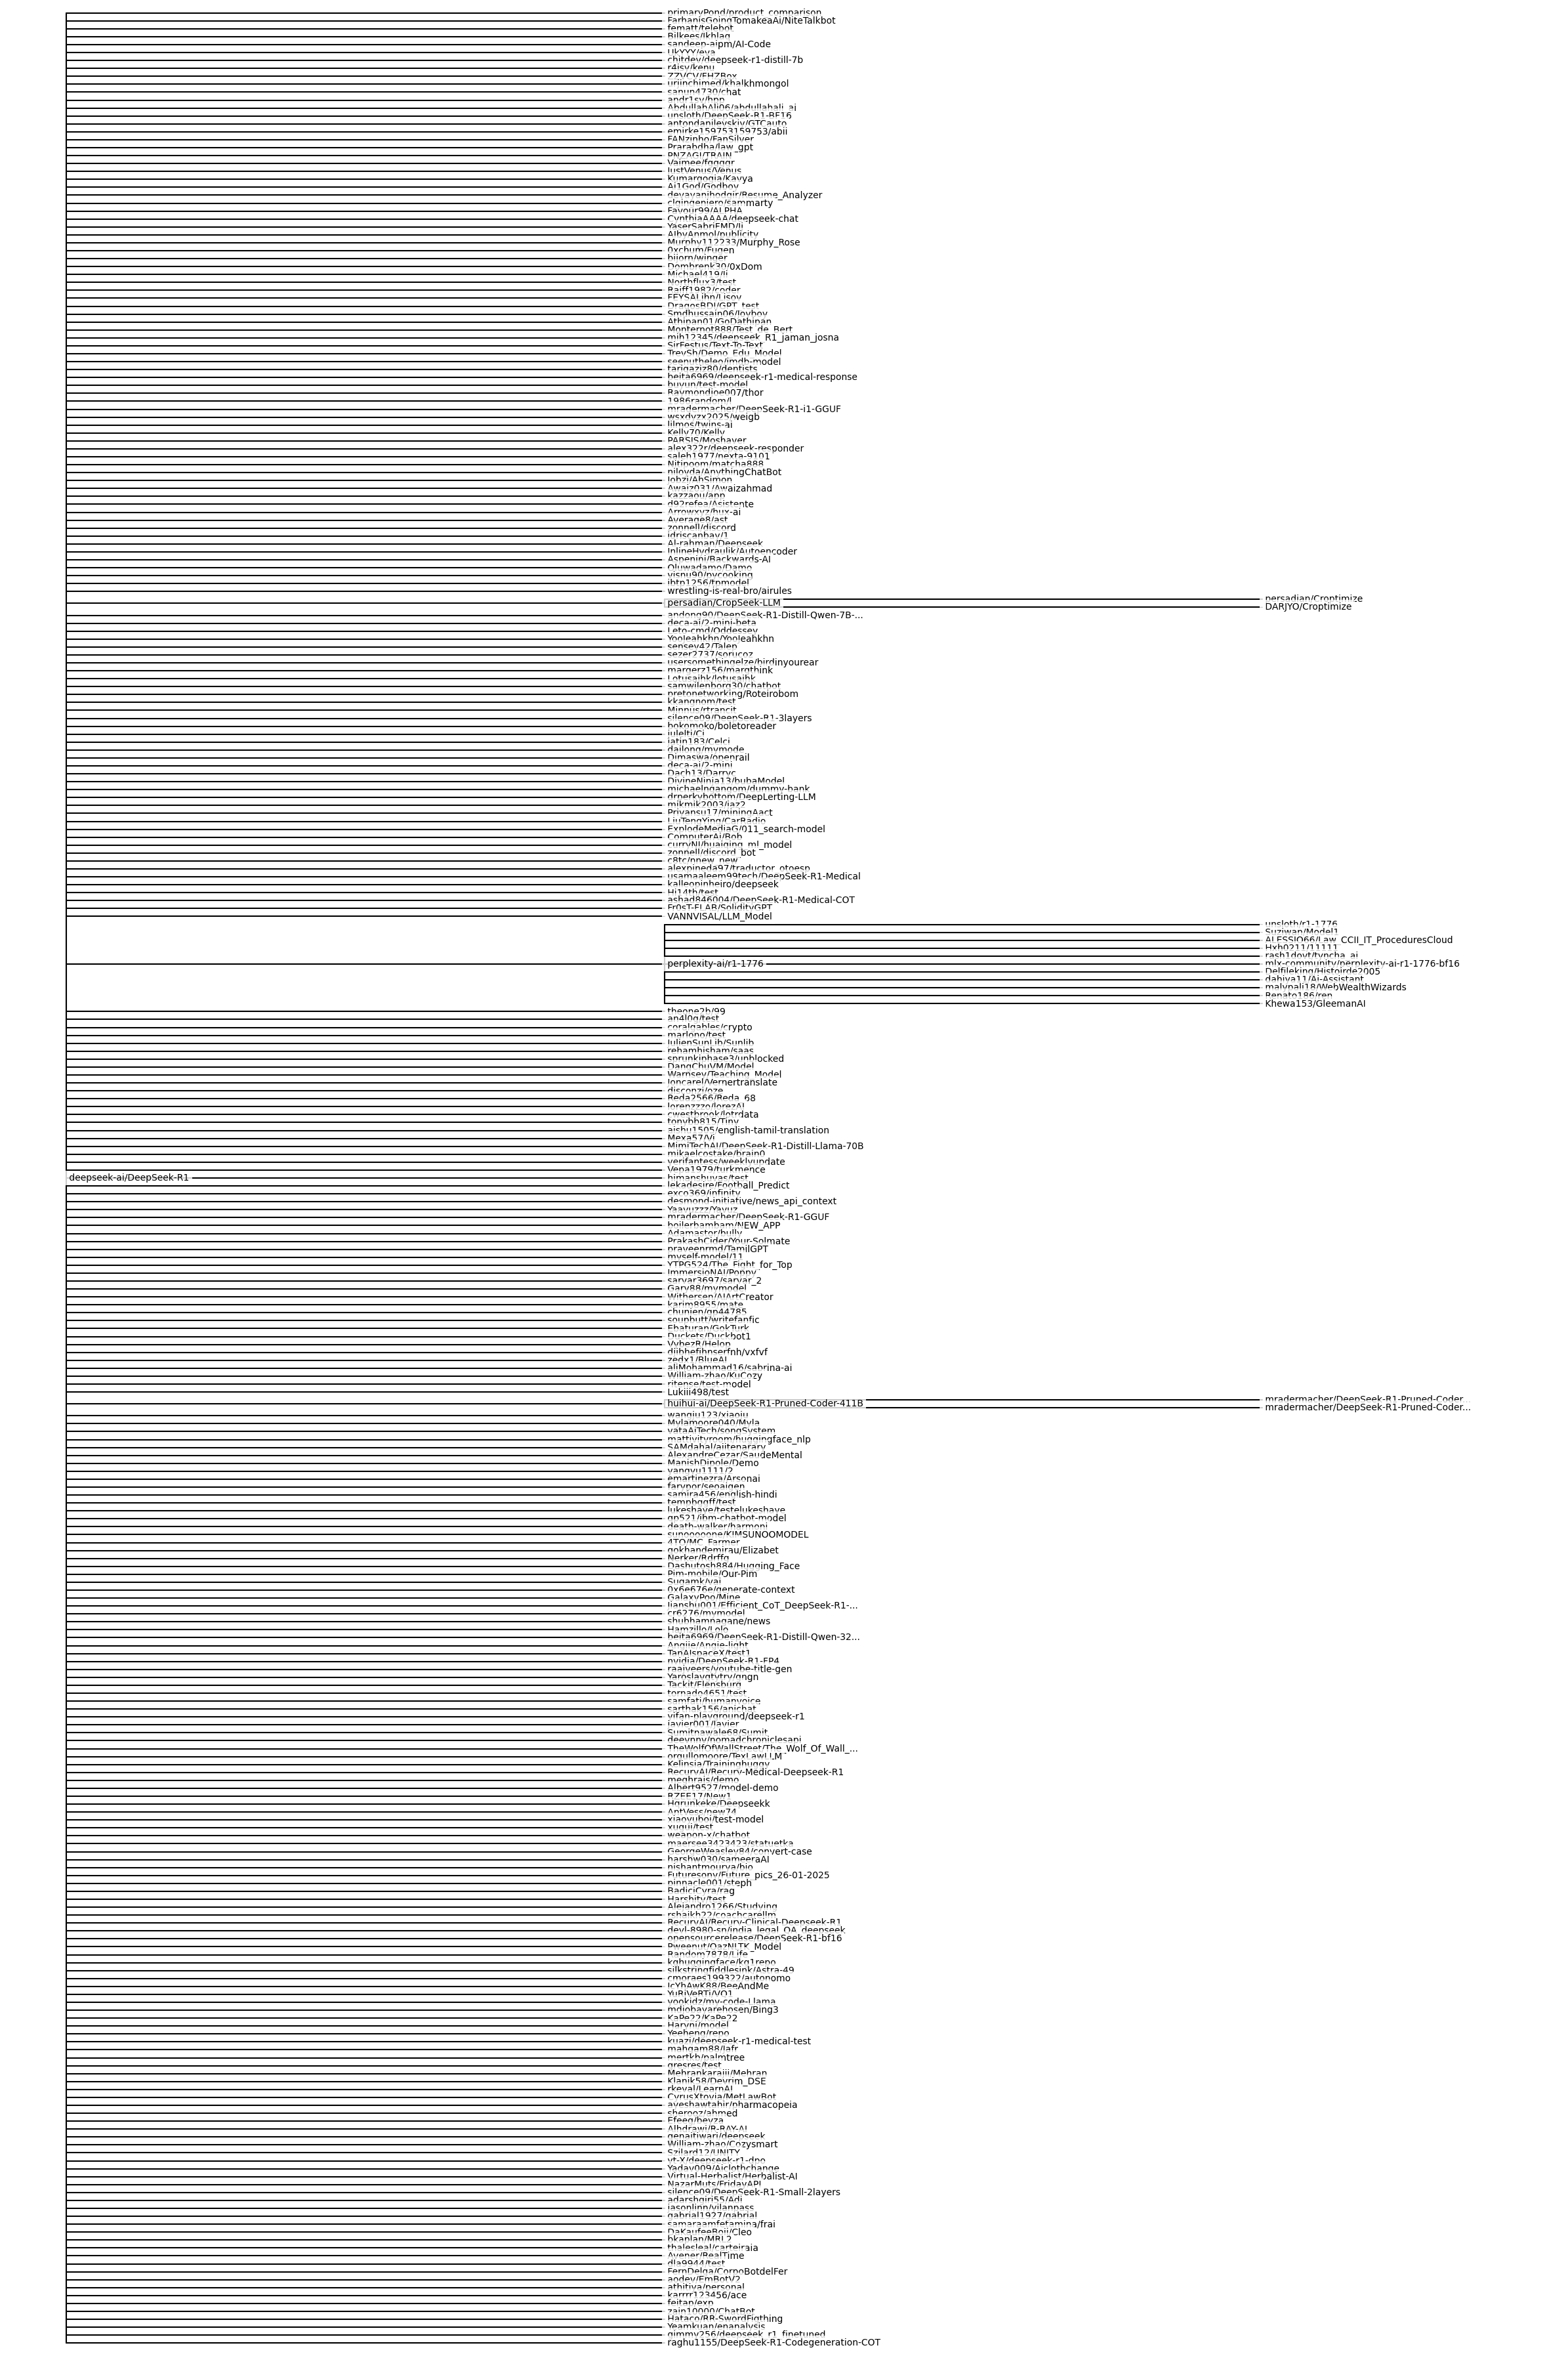

In [ ]:
!pip install Bio
!pip install pandas
import pandas as pd
import ast
import matplotlib.pyplot as plt
from Bio import Phylo
from Bio.Phylo.BaseTree import Clade, Tree

# Load and prepare tree
df = pd.read_csv("/content/DeepSeek-R1_finetunes_20250408_202441.csv")
df['children'] = df['children'].apply(ast.literal_eval)

def build_phylo_tree_from_dfs(df):
    clade_map = {row['model_id']: Clade(name=row['model_id']) for _, row in df.iterrows()}
    parent_links = {}
    for _, row in df.iterrows():
        parent = row['model_id']
        for child_url in row['children']:
            child = '/'.join(child_url.split("/")[-2:])
            parent_links[child] = parent
    all_models = set(df['model_id'])
    child_models = set(parent_links.keys())
    root_model_id = list(all_models - child_models)[0]
    for child, parent in parent_links.items():
        if child in clade_map and parent in clade_map:
            clade_map[parent].clades.append(clade_map[child])
    return Tree(root=clade_map[root_model_id])

tree = build_phylo_tree_from_dfs(df)

# Plotting with labels on branches
fig = plt.figure(figsize=(24, 36))
ax = fig.add_subplot(1, 1, 1)

# Draw the tree without axes
Phylo.draw(tree, axes=ax, do_show=False)

# Remove all axes elements
ax.set_axis_off()
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

# Ensure labels are positioned away from branch lines
for label in ax.texts:
    pos = label.get_position()
    label.set_position((pos[0], pos[1]))
    label.set_bbox(dict(facecolor='white', alpha=0.8, edgecolor='none', pad=3))

plt.tight_layout()
plt.savefig('clean_phylogenetic_tree.png', dpi=200, bbox_inches='tight')
plt.show()

In [ ]:
!apt install graphviz libgraphviz-dev
!pip install pygraphviz
import pandas as pd
import ast
import matplotlib.pyplot as plt
import networkx as nx

# Load and prepare the dataset
df = pd.read_csv("/content/DeepSeek-R1_finetunes_20250408_202441.csv")
df['children'] = df['children'].apply(ast.literal_eval)

# Create a directed graph
G = nx.DiGraph()

# Add nodes and edges
for _, row in df.iterrows():
    parent = row['model_id']
    G.add_node(parent)
    for child_url in row['children']:
        child = '/'.join(child_url.split("/")[-2:])
        G.add_node(child)
        G.add_edge(parent, child)

# Find root node
root = [n for n, d in G.in_degree() if d == 0][0]

# Create a hierarchical layout
pos = nx.nx_agraph.graphviz_layout(G, prog='dot', root=root)

# Create figure
plt.figure(figsize=(16, 24))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=10, node_color='white', edgecolors='black')

# Draw edges
nx.draw_networkx_edges(G, pos, arrows=False)

# Draw labels, rotating only non-root nodes
label_pos = {k: (v[0], v[1]) for k, v in pos.items()}
for node, (x, y) in label_pos.items():
    if node != root:  # Rotate labels for non-root nodes
        plt.text(x, y, s=node, rotation=90, ha='center', va='center', fontsize=9)
    else:  # Keep root label horizontal
        plt.text(x, y, s=node, ha='center', va='center', fontsize=9)

# Remove axes
plt.axis('off')
plt.tight_layout()

# Save the figure
plt.savefig("mistral_finetune_tree_networkx.png", dpi=150, bbox_inches='tight')
plt.show()

print("Tree visualization saved to mistral_finetune_tree_networkx.png")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
graphviz is already the newest version (2.42.2-6ubuntu0.1).
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 30 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 

FileNotFoundError: [Errno 2] No such file or directory: '/content/DeepSeek-R1_finetunes_20250408_202441.csv'

In [ ]:
!pip install ete3
!pip install tree
!pip install PyQt5
import pandas as pd
import ast
from ete3 import Tree, faces, AttrFace, TreeStyle


# Load and prepare the dataset
df = pd.read_csv("/content/DeepSeek-R1_finetunes_20250408_202441.csv")
df['children'] = df['children'].apply(ast.literal_eval)

# Function to build the ete3 tree recursively
def build_ete3_tree(df, parent_node=None, parent_name=None):
    if parent_node is None:
        # Create the root node if it's the first call
        root_name = df.loc[df['depth'] == 0, 'model_id'].iloc[0]
        tree = Tree(name=root_name)
        parent_node = tree
    else:
        tree = parent_node  # Continue building the existing tree

    # Find children of the current parent
    children_rows = df.loc[df['model_id'] == parent_name]
    if not children_rows.empty:
        children_urls = children_rows['children'].iloc[0]
        for child_url in children_urls:
            child_name = '/'.join(child_url.split("/")[-2:])
            child_node = tree.add_child(name=child_name)
            build_ete3_tree(df, child_node, child_name)  # Recursive call
    return tree

# Build the tree
tree = build_ete3_tree(df)

# Style the tree
ts.show_leaf_name = False  # Hide leaf names
ts.mode = "c"  # Circular tree layout
ts.root_opening_factor = 1  # Adjust root opening for circular layout

# Style the nodes
nst = NodeStyle()
nst["size"] = 0  # Hide node circles
nst["hz_line_width"] = 2
nst["vt_line_width"] = 2

for n in tree.traverse():
    n.set_style(nst)
    # Add model name as a branch label
    name_face = TextFace(n.name, fsize=10, fgcolor="black")
    n.add_face(name_face, column=0, position="branch-right")

# Render and save the tree
tree.render("mistral_finetune_tree_ete3.png", tree_style=ts, dpi=300)
print("Tree visualization saved to mistral_finetune_tree_ete3.png")

ImportError: cannot import name 'faces' from 'ete3' (/usr/local/lib/python3.11/dist-packages/ete3/__init__.py)

In [ ]:
import requests
import pandas as pd
import datetime
import json
import csv
from huggingface_hub import HfApi, hf_hub_download
from bs4 import BeautifulSoup
import re
import os
import glob

api = HfApi()
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Validate Hugging Face model URL
def validate_hf_model_url(url):
    pattern = r"^https://huggingface.co/([\w\-]+)/([\w\-]+)$"
    match = re.match(pattern, url)
    return match.groups() if match else None

# Scrape Hugging Face model card page to find fine-tunes
def get_finetuned_models_page(model_org, model_name):
    search_url = f"https://huggingface.co/models?other=base_model:finetune:{model_org}/{model_name}"
    response = requests.get(search_url)
    if response.status_code == 200:
        soup = BeautifulSoup(response.text, "html.parser")
        model_divs = soup.find_all("div", class_="w-full truncate")
        model_links = []
        for div in model_divs:
            header = div.find("header")
            if header:
                model_link = header.get("title")
                if model_link:
                    model_links.append(f"https://huggingface.co/{model_link}")
        return model_links
    return []

# DFS for recursively discovering fine-tunes
def dfs_finetunes(model_url, visited, depth=0, results=None):
    if results is None:
        results = []

    if model_url in visited:
        return results
    visited.add(model_url)

    validated = validate_hf_model_url(model_url)
    if not validated:
        print(f"Invalid URL skipped: {model_url}")
        return results

    model_org, model_name = validated
    model_id = f"{model_org}/{model_name}"
    print(f"\n{'  '*depth}Fetching metadata for: {model_id}")

    try:
        model_metadata = api.model_info(model_id).__dict__
        json_metadata = json.dumps(model_metadata, default=str)

        # Try to download model card if available
        try:
            model_card = hf_hub_download(repo_id=model_id, filename='README.md')
            with open(model_card, 'r', encoding='utf-8') as f:
                card_content = f.read()
        except Exception as card_error:
            print(f"Could not download model card: {card_error}")
            card_content = ""

    except Exception as e:
        print(f"Error fetching metadata: {e}")
        return results

    finetune_links = get_finetuned_models_page(model_org, model_name)
    finetune_links = list(set(finetune_links))
    print(f"{'  '*depth}Found {len(finetune_links)} fine-tunes at depth {depth}.")

    results.append({
        "model_id": model_id,
        "metadata": json_metadata,
        "depth": depth,
        "children": finetune_links,
        "children_count": len(finetune_links),
        "card_data": card_content
    })

    for link in finetune_links:
        dfs_finetunes(link, visited, depth + 1, results)

    return results

# Save results
def save_json(results, model_name):
    filename = f"{model_name}_finetunes_{timestamp}.json"
    with open(filename, "w", encoding="utf-8") as f:
        json.dump({"models": results}, f, indent=4, default=str)
    print(f"Saved JSON: {filename}")

def save_csv(results, model_name):
    filename = f"{model_name}_finetunes_{timestamp}.csv"

    # Extract relevant fields for CSV
    csv_data = []
    for item in results:
        record = {
            "model_id": item["model_id"],
            "depth": item["depth"],
            "children_count": item["children_count"],
        }
        csv_data.append(record)

    df = pd.DataFrame(csv_data)
    df.to_csv(filename, index=False)
    print(f"Saved CSV: {filename}")

# Batch runner: takes a CSV of model URLs and runs everything
def run_batch_from_csv(csv_path, url_column="model_url"):
    # Handle wildcard in csv_path
    if '*' in csv_path:
        csv_files = glob.glob(csv_path)
        if not csv_files:
            print(f"No CSV files found matching pattern: {csv_path}")
            return

        print(f"Found {len(csv_files)} CSV files: {csv_files}")
        csv_path = csv_files[0]  # Use the first matching file

    try:
        input_df = pd.read_csv(csv_path)
        if url_column not in input_df.columns:
            print(f"Column '{url_column}' not found. Available columns: {input_df.columns.tolist()}")
            return

        for url in input_df[url_column].dropna().unique():
            print(f"Processing URL: {url}")
            visited = set()
            results = dfs_finetunes(url.strip(), visited)
            if results:
                model_name = results[0]["model_id"].split("/")[-1]
                save_json(results, model_name)
                save_csv(results, model_name)
            else:
                print(f"No fine-tunes found for {url}")
    except Exception as e:
        print(f"Error processing CSV: {e}")


if __name__ == "__main__":
    # Use glob to find CSV files in current directory if no specific file is provided
    csv_files = glob.glob("*.csv")
    if csv_files:
        print(f"Found CSV files: {csv_files}")
        run_batch_from_csv(csv_files[0], url_column="model_url")
    else:
        print("No CSV files found in current directory. Please provide a CSV file with model URLs.")

Found CSV files: ['DeepHermes-3-Mistral-24B-Preview_finetunes_20250414_201919.csv']
Column 'model_url' not found. Available columns: ['Unnamed: 0', 'model_id', 'card', 'metadata', 'depth', 'children', 'children_count']


To get models and fine-tunes with adapters

In [ ]:
import requests
import pandas as pd
import datetime
import json
import csv
from huggingface_hub import HfApi, hf_hub_download
from bs4 import BeautifulSoup
import re
import os
import glob

# Initialize API
api = HfApi()
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# Function to validate Hugging Face model URL
def validate_hf_model_url(url):
    pattern = r"^https://huggingface.co/([\w\-]+)/([\w\-]+)$"
    match = re.match(pattern, url)
    return match.groups() if match else None

# Function to get adapter models that use a base model
def get_adapter_models(model_org, model_name):
    all_adapter_links = []  # Store all links across pages
    page_num = 0
    adapter_types = ["adapter", "peft", "lora"]

    for adapter_type in adapter_types:
        page_num = 0
        while True:
            # Search for adapters that reference this model
            search_url = f"https://huggingface.co/models?other={adapter_type}:base_model:{model_org}/{model_name}&p={page_num}"
            print(f"  Scanning {adapter_type} adapter page {page_num}: {search_url}")
            response = requests.get(search_url)
            if response.status_code != 200:
                break  # Exit if page not found

            soup = BeautifulSoup(response.text, "html.parser")
            model_divs = soup.find_all("div", class_="w-full truncate")
            if not model_divs:
                break  # Exit if no more models on the page

            page_links = []
            for div in model_divs:
                header = div.find("header")
                if header:
                    model_link = header.get("title")
                    if model_link:
                        page_links.append(f"https://huggingface.co/{model_link}")

            if not page_links:
                break  # No more models found

            all_adapter_links.extend(page_links)
            print(f"  Found {len(page_links)} {adapter_type} adapter models on page {page_num}")
            page_num += 1  # Move to the next page

    return list(set(all_adapter_links))  # Remove duplicates

# Function to get model card
def get_model_card(model_id):
    try:
        # Try to download model card if available
        readme_path = hf_hub_download(repo_id=model_id, filename='README.md')
        with open(readme_path, 'r', encoding='utf-8') as f:
            card_content = f.read()
        return card_content
    except Exception as e:
        print(f"  Could not download model card: {str(e)[:100]}...")
        return ""

# Function to extract adapter config if available
def get_adapter_config(model_id):
    try:
        # Try to download adapter_config.json if available
        config_path = hf_hub_download(repo_id=model_id, filename='adapter_config.json')
        with open(config_path, 'r', encoding='utf-8') as f:
            config_content = json.load(f)
        return config_content
    except Exception:
        # Try alternative config files
        try:
            config_path = hf_hub_download(repo_id=model_id, filename='config.json')
            with open(config_path, 'r', encoding='utf-8') as f:
                config_content = json.load(f)
            return config_content
        except Exception as e:
            print(f"  Could not download adapter config: {str(e)[:100]}...")
            return {}

# Filter metadata to keep only important fields
def filter_metadata(metadata_dict):
    keys_to_keep = ["modelId", "sha", "tags", "downloads", "pipeline_tag", "lastModified"]
    return {k: metadata_dict.get(k) for k in keys_to_keep if k in metadata_dict}

# Get the base model from adapter config
def extract_base_model_from_config(config):
    # Different adapter types store base model info differently
    if isinstance(config, dict):
        # Try common keys where base model might be stored
        base_model_keys = [
            "base_model_name_or_path",
            "model_name_or_path",
            "base_model",
            "_name_or_path",
            "model_type"
        ]

        for key in base_model_keys:
            if key in config and config[key]:
                return config[key]

    return None

# Parse README for base model information
def extract_base_model_from_readme(card_text):
    if not card_text:
        return None

    # Common patterns in model cards that mention base models
    patterns = [
        r"base model:?\s*\[?([a-zA-Z0-9\-\/]+)\]?",
        r"based on:?\s*\[?([a-zA-Z0-9\-\/]+)\]?",
        r"adapter for:?\s*\[?([a-zA-Z0-9\-\/]+)\]?",
        r"fine-tuned from:?\s*\[?([a-zA-Z0-9\-\/]+)\]?",
        r"fine-tune of:?\s*\[?([a-zA-Z0-9\-\/]+)\]?",
    ]

    for pattern in patterns:
        matches = re.search(pattern, card_text, re.IGNORECASE)
        if matches:
            return matches.group(1).strip()

    return None

# Determine the type of adapter
def determine_adapter_type(config, card_text, metadata):
    # Check in config
    if isinstance(config, dict):
        if "peft_type" in config:
            return config["peft_type"]
        if "adapter_type" in config:
            return config["adapter_type"]

    # Check in tags from metadata
    if hasattr(metadata, "tags") and metadata.tags:
        for tag in metadata.tags:
            if tag.lower() in ["lora", "qlora", "peft", "adapter"]:
                return tag

    # Check in README
    if card_text:
        for adapter_type in ["LoRA", "QLoRA", "PEFT", "Adapter"]:
            if re.search(r'\b' + re.escape(adapter_type) + r'\b', card_text, re.IGNORECASE):
                return adapter_type

    return "Unknown"

# Recursive DFS (depth-first search) for finding models and their adapters
def dfs_models_and_adapters(model_url, visited, depth=0, results=None):
    if results is None:
        results = []

    if model_url in visited:
        return results
    visited.add(model_url)

    validated = validate_hf_model_url(model_url)
    if not validated:
        print(f"Invalid URL skipped: {model_url}")
        return results

    model_org, model_name = validated
    model_id = f"{model_org}/{model_name}"

    print(f"\n{'  ' * depth}Fetching metadata for: {model_id}")
    try:
        # Get model metadata
        model_metadata = api.model_info(model_id).__dict__
        filtered_metadata = filter_metadata(model_metadata)
        json_metadata = json.dumps(filtered_metadata, default=str)

        # Get model card
        model_card = get_model_card(model_id)

        # Get adapter config
        adapter_config = get_adapter_config(model_id)

        # Try to determine base model
        base_model = extract_base_model_from_config(adapter_config)
        if not base_model:
            base_model = extract_base_model_from_readme(model_card)

        adapter_config_json = json.dumps(adapter_config, default=str)

    except Exception as e:
        print(f"Error fetching metadata: {e}")
        return results

    adapter_links = get_adapter_models(model_org, model_name)
    print(f"{'  ' * depth}Found {len(adapter_links)} adapter models at depth {depth}.")

    results.append({
        "model_id": model_id,
        "card": model_card,
        "metadata": json_metadata,
        "adapter_config": adapter_config_json,
        "base_model": base_model,
        "depth": depth,
        "adapter_links": adapter_links,  # Store adapter links here
        "children_count": len(adapter_links),
        "adapter_type": determine_adapter_type(adapter_config, model_card, model_metadata)
    })

    # Recursively search for adapters of adapters
    for link in adapter_links:
        dfs_models_and_adapters(link, visited, depth + 1, results)

    return results

# Function to save results as JSON
def save_json(results, model_name):
    filename = f"{model_name}_adapters_tree_{timestamp}.json"
    data = {
        "models": results
    }
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(data, f, indent=4, default=str)
    print(f"Results saved to {filename}")

# Function to save results as CSV (pandas)
def save_csv(results, model_name):
    filename = f"{model_name}_adapters_tree_{timestamp}.csv"

    # Flatten the adapter_links list for CSV export
    for item in results:
        item['adapter_links'] = ', '.join(item['adapter_links'])  # Convert list to string

    df = pd.DataFrame(results)
    df.to_csv(filename, index=False, encoding="utf-8", quoting=csv.QUOTE_ALL)
    print(f"Results saved to {filename}")

# Main execution
if __name__ == "__main__":
    model_url = input("Enter the Hugging Face model URL: ").strip()
    visited = set()
    results = dfs_models_and_adapters(model_url, visited)

    if results:
        model_name = results[0]["model_id"].split("/")[-1]
        save_json(results, model_name)
        save_csv(results, model_name)
    else:
        print("No adapter models found.")


Enter the Hugging Face model URL: https://huggingface.co/perplexity-ai/r1-1776

Fetching metadata for: perplexity-ai/r1-1776
  Scanning adapter adapter page 0: https://huggingface.co/models?other=adapter:base_model:perplexity-ai/r1-1776&p=0
  Scanning peft adapter page 0: https://huggingface.co/models?other=peft:base_model:perplexity-ai/r1-1776&p=0
  Scanning lora adapter page 0: https://huggingface.co/models?other=lora:base_model:perplexity-ai/r1-1776&p=0
Found 0 adapter models at depth 0.
Results saved to r1-1776_adapters_tree_20250414_231335.json
Results saved to r1-1776_adapters_tree_20250414_231335.csv
